In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
#import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
conn = engine.connect()

In [14]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine) 

## Bonus Challenge Assignment: Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    year, month, day = map(int,start_date.split('-'))
    start_date = dt(year, month, day)

    year, month, day = map(int,end_date.split('-'))
    end_date = dt(year, month, day)
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [22]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year = calc_temps('2017-08-01', '2017-08-07')
year

[(73.0, 80.04166666666667, 83.0)]

(0.0, 100.0)

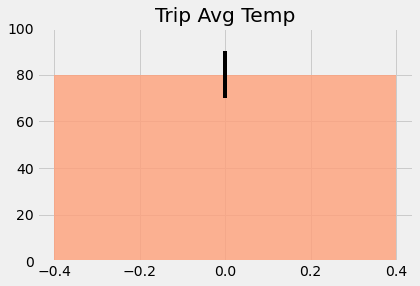

In [105]:
# Plot the results from your previous query as a bar chart. 
year_list = year[0]
year_list
year_min = year_list[0]
year_avg = year_list[1]
year_max = year_list[2]

error = year_max - year_min

# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.title("Trip Avg Temp")
plt.bar(x=0, height=year_avg, yerr=error, color ='lightsalmon', alpha =.8)
plt.ylim((0,100))

### Daily Rainfall Average

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
    
sel = [func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
      ]
    
start_date = dt(2017, 8, 1)
end_date = dt(2017, 8, 7)
    
    
results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()
    
results


[(0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.1, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)]

In [91]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):

    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [92]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt(2017, 7, 31)
end_date = dt(2017, 8, 7)

# Use the start and end date to create a range of dates
results = session.query(Measurement.date).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(Measurement.date).\
    group_by(Measurement.date).all()

trip_dates = list(np.ravel(results))
trip_dates
# Strip off the year and save a list of strings in the format %m-%d
dates = (datetime.strptime(dr, '%Y-%m-%d') for dr in trip_dates)
date_strings = [datetime.strftime(d, '%m-%d') for d in dates]

print(date_strings)

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals=[]

for date in date_strings:
    normals.append(daily_normals(date))

print(normals)

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']
[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [93]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#unpack list of list of tuples
normals_df =pd.DataFrame([t for lst in normals for t in lst], columns=['minimum', 'average', 'maximum'])                    
#add column for trip_dates
normals_df['dates'] = trip_dates
#set date column as index
normals_df.set_index('dates')

,minimum,average,maximum
dates,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


Text(0, 0.5, 'Temperature')

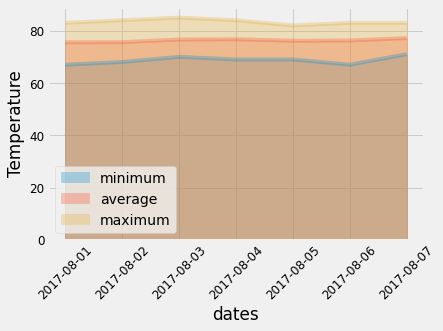

In [94]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, alpha=.3, x='dates', rot=45, fontsize=12)
ax.set_ylabel('Temperature')

## Close Session

In [95]:
session.close()